In [37]:
import scipy
import scipy.io as sio
import numpy as np
from keras.models import save_model, load_model, Model
import matplotlib.pyplot as plt
import os 
from skimage import io
from skimage.transform import resize
from sklearn import preprocessing
from keras.engine.topology import Layer
import keras.backend as K

In [90]:
load_file = 'train&test/test/reconstruct/'
# load_file = 'train&test/train/low_count/'
system_matrix = 'sinogramFactory/sinogramFactory/'
A_mat = sio.loadmat(system_matrix+'Amat.mat')    #衰减后系统矩阵
load_data = sio.loadmat(load_file+'80_layer_noise_0_1.36E6_2.mat')
# load_data = sio.loadmat(load_file+'18_layer_noise_0_6.8E6_2.mat')
# load_data = sio.loadmat('D:/Experiment/PET-TV/mat_phantom/1_layer_noise_0_6.8E6_2')

设置图像大小，读入数据

In [91]:
#get train and test
input_size_row = 128  #图像大小
input_size_col = 128


filename_X = os.listdir('train&test/train/low_count')   #training data
filename_Y = os.listdir('train&test/train/high_count') #label

filetest_X = os.listdir('train&test/test/low')
filetest_Y = os.listdir('train&test/test/high')

In [92]:
# P_sys = A_mat['A'].toarray()  #system matrix
P_sys = A_mat['A']
Recondata = load_data['ReconData']
Recondata = Recondata[0,0]

Y = Recondata[0].copy()     #observed data(detector)
Y = np.reshape(Y,[Y.shape[0]*Y.shape[1],1], order = 'F')
noise = Recondata[1].copy()   #scatter and random event
x = Recondata[2].copy()      #initialize lambda
ground_truth = Recondata[4].copy()  #ground truth image

In [72]:
#EM
def EM(iteration, P, p, y, x_em, gamma, notzero):

    for i in range(iteration):
        temp = P.T.dot(y/(P.dot(x_em)+gamma))[notzero]
        x_em[notzero] = np.multiply(x_em[notzero]/p.T[notzero] , temp)

    return x_em

#  SAGAN  x =  gamma * o + x
class Gamma(Layer):

    def __init__(self, **kwargs):
        super(Gamma, self).__init__(**kwargs)

    def build(self, input_shape):

        self._x = K.variable(0.0,name='gamma')
        self.trainable_weights = [self._x]

        super(Gamma, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        O, X = x
        result = self._x*O + X
        return result

    def compute_output_shape(self, input_shape):
        return input_shape[0]
    
def get_test_data(filename_X, filename_Y, input_size_row, input_size_col):  #不除200
    for i in range(len(filename_X)):
        if i == 0:
            img1 = sio.loadmat('train&test/test/low/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/test/high/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')

            
            batch_X = img1
            batch_Y = img2
            

        else:
            img1 = sio.loadmat('train&test/test/low/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/test/high/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            
            batch_X = np.concatenate((batch_X, img1), axis = 0)
            batch_Y = np.concatenate((batch_Y, img2), axis = 0)
            
        
    return  batch_X, batch_Y    

def getdata(filename_X, filename_Y, input_size_row, input_size_col):
    for i in range(len(filename_X)):
        if i == 0:
            img1 = sio.loadmat('train&test/train/low_count/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            img1 = img1/100
            img2 = img2/100
            
            batch_X = img1
            batch_Y = img2
            

        else:
            img1 = sio.loadmat('train&test/train/low_count/'+filename_X[i])
            img1 = img1['f_EM'].copy()
            img1 = np.reshape(img1,[1, input_size_row, input_size_col, 1],order='F')

            img2 = sio.loadmat('train&test/train/high_count/'+filename_Y[i])
            img2 = img2['f_EM'].copy()
            img2 = np.reshape(img2,[1, input_size_row, input_size_col, 1],order='F')
            
            img1 = img1/100
            img2 = img2/100
            
            batch_X = np.concatenate((batch_X, img1), axis = 0)
            batch_Y = np.concatenate((batch_Y, img2), axis = 0)
            
        
    return  batch_X, batch_Y

In [97]:
# model = load_model('new_unet.h5')
# model = load_model('unet_denoise.h5')
model = load_model('Generator_2.h5',custom_objects={'Gamma': Gamma()})

D:\Applications\Anaconda\Anaconda3\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


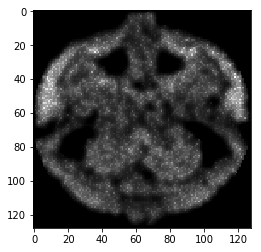

0.0

In [31]:
#ADMM     SAGAN #######  
# modules = 5
x = Recondata[2].copy()      #initialize lambda
p_j = P_sys.sum(axis = 0)
x_not_zero = np.where(p_j > 1e-10)
MaxIt = 5
SubIt = 30
L = 2  #penalize
scale = 400

#Mapemnet
x_em = np.zeros([128*128 ,1])
x_penal = np.zeros([128*128 ,1])
mu = np.zeros([128*128 ,1])

x_em = EM(30, P_sys, p_j, Y, x, noise, x_not_zero[1])  #warming up


z = np.reshape(x_em,(1, 128, 128, 1), order='F')       #z intialize
z = model.predict(z/scale)
z = np.reshape(z, [128*128, 1],order = 'F')
negative = np.where(z < 0)
z[negative] = 0


# mu = x_em - z         #mu初始化

p_j = np.array(p_j)
prior = z - mu - p_j.T/L
x_penal = x_em   # x初始化

for i in range(MaxIt):
    for i in range(SubIt):
            x_em = EM(1, P_sys, p_j, Y, x_penal, noise, x_not_zero[1])

            x_penal = 1/2 * prior + 1/2 *np.sqrt(prior**2 + 4* x_em*x_penal/L)
            
            mu = mu + x_penal - x_em
            prior = x_penal - mu - p_j.T/L
        
    z = np.reshape(x_penal,(1, 128, 128, 1), order='F')      
    z = model.predict(z/scale)
    z = np.reshape(z, [128*128, 1],order = 'F')
    negative = np.where(z < 0)
    z[negative] = 0
    mu = mu + x_penal - z
    prior = z - mu - p_j.T/L
    x_penal = EM(25, P_sys, p_j, Y, z, noise, x_not_zero[1])

            
#     mu = mu + x_penal - z
#     prior = z - mu - p_j.T/L
    
#ADMM
d = x_penal
d = np.reshape(d,(1, 128, 128, 1), order='F')
plt.figure()
plt.imshow(d[0, :, :, 0],plt.cm.gray)    #输出
plt.show()
x_penal.min()         

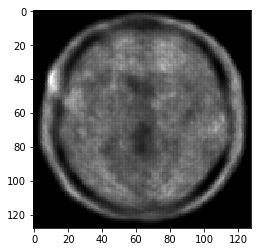

7.9076543

In [100]:
#EM+net+EM  lowcount denoise后采取一定步数的EM可以起到一定恢复纹理作用
scale = 100
p_j = P_sys.sum(axis = 0)
x = Recondata[2].copy() 


g = EM(50, P_sys, p_j, Y, x, noise, x_not_zero[1])

for iteration in range(2):
    g = np.reshape(g,(1, 128, 128, 1), order='F')
    z = model.predict(g/scale)
    
    z = np.reshape(z,[128*128,1],order='F')
    negative = np.where(z < 0)
    z[negative] = 0
    z = z*10
    g = EM(10, P_sys, p_j, Y, z, noise, x_not_zero[1])

g = np.reshape(g,(1, 128, 128, 1), order='F')


plt.figure()
plt.imshow(g[0,:,:,0],plt.cm.gray)    #输出
plt.show()
g.max()

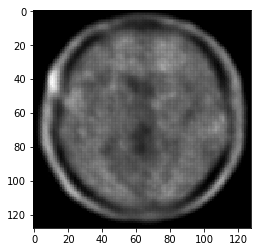

In [98]:
#EM + SAGAN lowcount
scale = 100
p_j = P_sys.sum(axis = 0)
x = Recondata[2].copy() 


g = EM(50, P_sys, p_j, Y, x, noise, x_not_zero[1])
g = np.reshape(g,(1, 128, 128, 1), order='F')
z = model.predict(g/scale)

plt.figure()
plt.imshow(z[0,:,:,0],plt.cm.gray)    #输出
plt.show()
z.max()
g = z

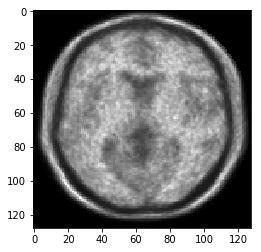

In [64]:
# test_X, test_Y = get_test_data(filetest_X, filetest_Y, input_size_row, input_size_col)
plt.figure()
plt.imshow(test_Y[2,:,:,0],plt.cm.gray)    #输出
plt.show()

In [42]:
x = Recondata[2].copy()      #initialize lambda
p_j = P_sys.sum(axis = 0)
x_not_zero = np.where(p_j > 1e-10)
MaxIt = 5
SubIt = 30
L = 2  #penalize
scale = 100

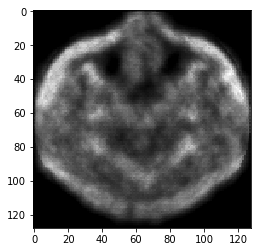

0.0

In [39]:
#ADMM     high count Unet,6.8E6#######  
# modules = 5
x = Recondata[2].copy()      #initialize lambda
p_j = P_sys.sum(axis = 0)
x_not_zero = np.where(p_j > 1e-10)
MaxIt = 5
SubIt = 30
L = 2  #penalize
scale = 300

#Mapemnet
x_em = np.zeros([128*128 ,1])
x_penal = np.zeros([128*128 ,1])
mu = np.zeros([128*128 ,1])

x_em = EM(30, P_sys, p_j, Y, x, noise, x_not_zero[1])  #warming up


z = np.reshape(x_em,(1, 128, 128, 1), order='F')       #z intialize
z = model.predict(z/scale)
z = np.reshape(z, [128*128, 1],order = 'F')
negative = np.where(z < 0)
z[negative] = 0


# mu = x_em - z         #mu初始化

p_j = np.array(p_j)
prior = z - mu - p_j.T/L
x_penal = x_em   # x初始化

for i in range(MaxIt):
    for i in range(SubIt):
            x_em = EM(1, P_sys, p_j, Y, x_penal, noise, x_not_zero[1])

            x_penal = 1/2 * prior + 1/2 *np.sqrt(prior**2 + 4* x_em*x_penal/L)
            
            mu = mu + x_penal - x_em
            prior = x_penal - mu - p_j.T/L
        
    z = np.reshape(x_penal,(1, 128, 128, 1), order='F')      
    z = model.predict(z/scale)
    z = np.reshape(z, [128*128, 1],order = 'F')
    negative = np.where(z < 0)
    z[negative] = 0
    mu = mu + x_penal - z
    prior = z - mu - p_j.T/L
    x_penal = EM(25, P_sys, p_j, Y, z, noise, x_not_zero[1])

            
#     mu = mu + x_penal - z
#     prior = z - mu - p_j.T/L
    
#ADMM
d = x_penal
d = np.reshape(d,(1, 128, 128, 1), order='F')
plt.figure()
plt.imshow(d[0, :, :, 0],plt.cm.gray)    #输出
plt.show()
x_penal.min()        

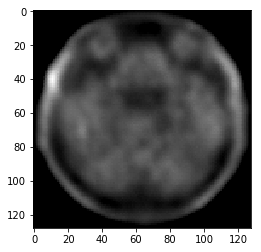

0.0

In [76]:
#em+denoise+em+denoise  越来越暗，而且纹理不会有所改善  
# x = Recondata[2].copy()      #initialize lambda
# p_j = P_sys.sum(axis = 0)
scale = 200
p_j = P_sys.sum(axis = 0)
r = Recondata[2].copy() 
for u in range(1):
    r = EM(50, P_sys, p_j, Y, r, noise, x_not_zero[1])
    r = np.reshape(r,(1,128, 128,1), order='F')

    r = model.predict(r/scale)
    r = np.reshape(r,(128*128, 1), order='F')
    negative = np.where(r < 0)
    r[negative] = 0

# r = EM(1, P_sys, p_j, Y, x, noise, x_not_zero[1])
r = np.reshape(r,(1,128, 128,1), order='F')
plt.figure()
plt.imshow(r[0, :, :, 0],plt.cm.gray)    #输出
plt.show()
r.min()


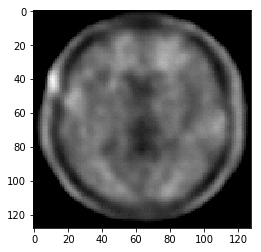

In [93]:
#EM + unet lowcount
scale = 200
p_j = P_sys.sum(axis = 0)
x = Recondata[2].copy() 


g = EM(50, P_sys, p_j, Y, x, noise, x_not_zero[1])
g = np.reshape(g,(1, 128, 128, 1), order='F')
z = model.predict(g/scale)
negative = np.where(z < 0)
z[negative] = 0

plt.figure()
plt.imshow(z[0,:,:,0],plt.cm.gray)    #输出
plt.show()
z.max()
g = z

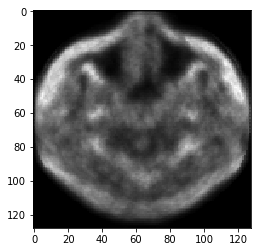

0.0

In [37]:
#EM+net+EM  denoise后采取一定步数的EM可以起到一定恢复纹理作用
scale = 200
p_j = P_sys.sum(axis = 0)
x = Recondata[2].copy() 
g = EM(150, P_sys, p_j, Y, x, noise, x_not_zero[1])
g = np.reshape(g,(1, 128, 128, 1), order='F')
z = model.predict(g/scale)
# z = np.reshape(z,[1,128,128,1],order='F')
# j = g + (z - g)
z = np.reshape(z,[128*128,1],order='F')
negative = np.where(z < 0)
z[negative] = 0
g = EM(25, P_sys, p_j, Y, z, noise, x_not_zero[1])
g = np.reshape(g,(1, 128, 128, 1), order='F')
# z = model.predict(g/scale)
# z = np.reshape(z,[128*128,1],order='F')
# negative = np.where(z < 0)
# z[negative] = 0
# g = np.reshape(z,(1, 128, 128, 1), order='F')
plt.figure()
plt.imshow(g[0,:,:,0],plt.cm.gray)    #输出
plt.show()
g.min()

In [8]:
sio.savemat('C:/Users/MaxMai/Desktop/EM/DIP/data/mo/Hayek_papatv_Aug_24/mapem_f2.mat',{'f': x_penal})

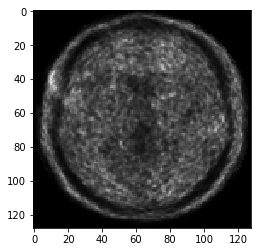

In [95]:
#EM
x = Recondata[2].copy() 
p_j = P_sys.sum(axis = 0)
g = EM(50, P_sys, p_j, Y, x, noise, x_not_zero[1])
g = np.reshape(g,(128, 128), order='F')
plt.figure()
plt.imshow(g,plt.cm.gray)    #输出
plt.show()

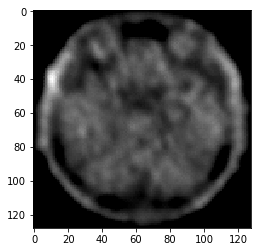

In [137]:
#em+unet
h = np.reshape(z,(1, 128, 128, 1), order='F')
plt.figure()
plt.imshow(h[0, :, :, 0],plt.cm.gray)    #输出
plt.show()

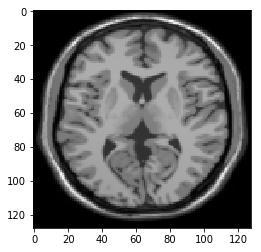

In [61]:
#ground_truth
test_X = io.imread('train&test/test/label/'+'80_layer_noise_0.png').astype("float")  #选第0张图片作测试
test_X = resize(test_X, [128, 128, 1], mode = 'constant')
test_X = np.reshape(test_X,(1, 128, 128, 1))
plt.figure()  #输入
plt.imshow(test_X[0, :, :, 0], plt.cm.gray)
plt.show()

In [ ]:
layer_model = Model(inputs=model.input, outputs=model.layers[0].output)
feature=layer_model.predict(test_X)
plt.figure()
plt.imshow(feature[0, :, :, 0],plt.cm.gray)    #输出
plt.show()

In [ ]:
#check the result, the end

img = np.reshape(g,[128,128], order='F')
scipy.misc.imsave('newdata2.jpg', img)
img.min()

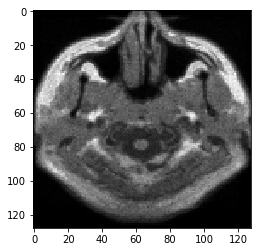

0.9271455054189645

In [209]:
#test
test_filename_X = os.listdir('train&test/test/test_X/')
test_X = io.imread('train&test/test/test_X/'+test_filename_X[0]).astype("float")  #选第0张图片作测试
test_X = resize(test_X, [128, 128, 1], mode = 'constant')
test_X = np.reshape(test_X,(1, 128, 128, 1))
plt.figure()  #输入
plt.imshow(test_X[0, :, :, 0], plt.cm.gray)
plt.show()
(test_X/255).max()